In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import glob, os
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
import copy
import seaborn as sns
from sklearn.neighbors import KernelDensity
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import shapely.geometry as sgeom
import warnings
%matplotlib inline

In [2]:
xr.__version__

'2023.5.0'

In [3]:
PHASE = 'Summer'
# PHASE = 'Winter'

lifetime_bounds = [2,80]
region = 'tropics'

# PF land fraction threshold to separate land vs. ocean MCS
land_frac_thresh = 0.7
ocean_frac_thresh = 0.1

if PHASE == 'Summer':
    track_period = '20160810_20160910'
    datetime_range = pd.to_datetime(['2016-08-10T00', '2016-09-11T00'])
    lon_bounds = [-180, 180]
    lat_bounds = [-15, 30]
if PHASE == 'Winter':
    track_period = '20200201_20200301'
    datetime_range = pd.to_datetime(['2020-02-01T00', '2020-03-01T00'])
    lon_bounds = [-180, 180]
    lat_bounds = [-20, 15]

rootdir = f'/pscratch/sd/f/feng045/DYAMOND/mcs_stats/{PHASE}/'
dir_PyFLEXTRKR = f'{rootdir}PyFLEXTRKR/'
dir_MOAAP = f'{rootdir}MOAAP/'
dir_TOOCAN = f'{rootdir}TOOCAN/'
dir_tobac = f'{rootdir}tobac/'
dir_TAMS = f'{rootdir}TAMS/'
dir_simpleTrack = f'{rootdir}simpleTrack/'

if PHASE == 'Summer':
    name_map = {
        'obs': 'OBS',
        'm1': 'ARPEGE',
        'm2': 'IFS',
        'm3': 'MPAS',
        'm4': 'NICAM',
        'm5': 'SAM',
        'm6': 'UM',
        'm7': 'FV3',
        # 'm8': 'ICON',
    }

if PHASE == 'Winter':
    name_map = {
        'obs': 'OBS',
        'm1': 'ARPEGE',
        'm2': 'IFS',
        'm3': 'MPAS',
        # 'm4': 'NICAM',
        'm5': 'SAM',
        'm6': 'UM',
        'm7': 'GRIST',
        'm8': 'SCREAM',
        'm9': 'XSHiELD',
        'm10': 'GEOS',
        'm11': 'ICON',
    }

# Input filenames
filenames_PyFLEXTRKR = {key:f'{dir_PyFLEXTRKR}mcs_stats_{PHASE}_{value}.nc' for key,value in name_map.items()}
filenames_MOAAP = {key:f'{dir_MOAAP}mcs_stats_{PHASE}_{value}.nc' for key,value in name_map.items()}
filenames_TOOCAN = {key:f'{dir_TOOCAN}mcs_stats_{PHASE}_{value}.nc' for key,value in name_map.items()}
filenames_tobac = {key:f'{dir_tobac}mcs_stats_{PHASE}_{value}.nc' for key,value in name_map.items()}
filenames_TAMS = {key:f'{dir_TAMS}mcs_stats_{PHASE}_{value}.nc' for key,value in name_map.items()}
filenames_simpleTrack = {key:f'{dir_simpleTrack}mcs_stats_{PHASE}_{value}.nc' for key,value in name_map.items()}

figdir = f'/global/cfs/cdirs/m1867/zfeng/MCSMIP/DYAMOND/{PHASE}/figures/MCSMIP/'
os.makedirs(figdir, exist_ok=True)
print(figdir)

/global/cfs/cdirs/m1867/zfeng/MCSMIP/DYAMOND/Summer/figures/MCSMIP/


## Check if input files exist

In [4]:
for key, value in filenames_PyFLEXTRKR.items():
    print(f'{value}: {os.path.isfile(value)}')

/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/PyFLEXTRKR/mcs_stats_Summer_OBS.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/PyFLEXTRKR/mcs_stats_Summer_ARPEGE.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/PyFLEXTRKR/mcs_stats_Summer_IFS.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/PyFLEXTRKR/mcs_stats_Summer_MPAS.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/PyFLEXTRKR/mcs_stats_Summer_NICAM.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/PyFLEXTRKR/mcs_stats_Summer_SAM.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/PyFLEXTRKR/mcs_stats_Summer_UM.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/PyFLEXTRKR/mcs_stats_Summer_FV3.nc: True


In [5]:
for key, value in filenames_MOAAP.items():
    print(f'{value}: {os.path.isfile(value)}')

/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/MOAAP/mcs_stats_Summer_OBS.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/MOAAP/mcs_stats_Summer_ARPEGE.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/MOAAP/mcs_stats_Summer_IFS.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/MOAAP/mcs_stats_Summer_MPAS.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/MOAAP/mcs_stats_Summer_NICAM.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/MOAAP/mcs_stats_Summer_SAM.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/MOAAP/mcs_stats_Summer_UM.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/MOAAP/mcs_stats_Summer_FV3.nc: True


In [6]:
for key, value in filenames_TOOCAN.items():
    print(f'{value}: {os.path.isfile(value)}')

/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/TOOCAN/mcs_stats_Summer_OBS.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/TOOCAN/mcs_stats_Summer_ARPEGE.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/TOOCAN/mcs_stats_Summer_IFS.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/TOOCAN/mcs_stats_Summer_MPAS.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/TOOCAN/mcs_stats_Summer_NICAM.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/TOOCAN/mcs_stats_Summer_SAM.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/TOOCAN/mcs_stats_Summer_UM.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/TOOCAN/mcs_stats_Summer_FV3.nc: True


In [7]:
for key, value in filenames_tobac.items():
    print(f'{value}: {os.path.isfile(value)}')

/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/tobac/mcs_stats_Summer_OBS.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/tobac/mcs_stats_Summer_ARPEGE.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/tobac/mcs_stats_Summer_IFS.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/tobac/mcs_stats_Summer_MPAS.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/tobac/mcs_stats_Summer_NICAM.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/tobac/mcs_stats_Summer_SAM.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/tobac/mcs_stats_Summer_UM.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/tobac/mcs_stats_Summer_FV3.nc: True


In [8]:
for key, value in filenames_TAMS.items():
    print(f'{value}: {os.path.isfile(value)}')

/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/TAMS/mcs_stats_Summer_OBS.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/TAMS/mcs_stats_Summer_ARPEGE.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/TAMS/mcs_stats_Summer_IFS.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/TAMS/mcs_stats_Summer_MPAS.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/TAMS/mcs_stats_Summer_NICAM.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/TAMS/mcs_stats_Summer_SAM.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/TAMS/mcs_stats_Summer_UM.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/TAMS/mcs_stats_Summer_FV3.nc: True


In [9]:
for key, value in filenames_simpleTrack.items():
    print(f'{value}: {os.path.isfile(value)}')

/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/simpleTrack/mcs_stats_Summer_OBS.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/simpleTrack/mcs_stats_Summer_ARPEGE.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/simpleTrack/mcs_stats_Summer_IFS.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/simpleTrack/mcs_stats_Summer_MPAS.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/simpleTrack/mcs_stats_Summer_NICAM.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/simpleTrack/mcs_stats_Summer_SAM.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/simpleTrack/mcs_stats_Summer_UM.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/simpleTrack/mcs_stats_Summer_FV3.nc: True


## Show a map for the subset region

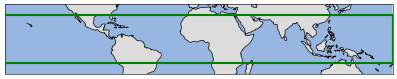

In [10]:
resolution = '110m'
# map_extent = [lon_bounds[0]-10,lon_bounds[1]+10,lat_bounds[0]-10,lat_bounds[1]+10]
map_extent = [lon_bounds[0],lon_bounds[1]-0.1,lat_bounds[0]-10,lat_bounds[1]+10]
land = cfeature.NaturalEarthFeature('physical', 'land', resolution)
ocean = cfeature.NaturalEarthFeature('physical', 'ocean', resolution)
borders = cfeature.NaturalEarthFeature('cultural', 'admin_0_boundary_lines_land', resolution)
states = cfeature.NaturalEarthFeature('cultural', 'admin_1_states_provinces_lakes', resolution)
proj = ccrs.PlateCarree(central_longitude=0)
box_proj = ccrs.PlateCarree(central_longitude=0)
fig = plt.figure(figsize=[10,10], dpi=50)
ax = plt.subplot(111, projection=proj)
ax.set_extent(map_extent, box_proj)
# Add land, coastlines, borders to inset
ax.add_feature(ocean, edgecolor='none', facecolor=cfeature.COLORS['water'])
ax.add_feature(land, facecolor='gainsboro', edgecolor='k')
# ax.add_feature(borders, edgecolor='k', facecolor='none')
# ax.add_feature(states, edgecolor='k', facecolor='none')
# Define the vertices of the rectangle in the projection coordinates
x1, y1 = proj.transform_point(lon_bounds[0], lat_bounds[0], proj)
x2, y2 = proj.transform_point(lon_bounds[1], lat_bounds[1], proj)
# Plot rectangle
ax.add_patch(mpl.patches.Rectangle((x1, y1), x2-x1, y2-y1, transform=proj, fill=None, lw=3, edgecolor='g', zorder=10))

In [11]:
# Read a sample data
ds_tmp = xr.open_dataset(filenames_PyFLEXTRKR['obs'])

# Get global attributes (assume the same for all data)
pixel_radius = ds_tmp.attrs['pixel_radius_km']
time_resolution = ds_tmp.attrs['time_resolution_hour']

# Convert lifetime bounds (hour) to track duration bounds
duration_bounds = (lifetime_bounds / time_resolution).astype(int)
duration_max = max(duration_bounds)

In [12]:
# xr.open_dataset(filenames_PyFLEXTRKR['obs']).isel({'times':slice(0,duration_max), 'nmaxpf':0})
# ds_pyflex = xr.open_mfdataset(list(filenames_PyFLEXTRKR.values()), combine='nested', concat_dim='source').isel({'times':})

In [13]:
# Read all files and combine them with a new dimension 'source'
ds_pyflex = xr.open_mfdataset(list(filenames_PyFLEXTRKR.values()), combine='nested', concat_dim='source').isel({'times':slice(0,duration_max), 'nmaxpf':0})
# Assign new coordinate 'source' using name_map dictionary keys
ds_pyflex['source'] = list(name_map.keys())
ds_pyflex

<xarray.Dataset>
Dimensions:                  (tracks: 4672, times: 80, source: 8)
Coordinates:
  * tracks                   (tracks) int64 0 1 2 3 4 ... 4668 4669 4670 4671
  * times                    (times) int64 0 1 2 3 4 5 6 ... 74 75 76 77 78 79
    nmaxpf                   int64 0
  * source                   (source) <U3 'obs' 'm1' 'm2' ... 'm5' 'm6' 'm7'
Data variables: (12/38)
    track_duration           (source, tracks) float64 dask.array<chunksize=(1, 4672), meta=np.ndarray>
    start_basetime           (source, tracks) datetime64[ns] dask.array<chunksize=(1, 4672), meta=np.ndarray>
    end_basetime             (source, tracks) datetime64[ns] dask.array<chunksize=(1, 4672), meta=np.ndarray>
    base_time                (source, tracks, times) datetime64[ns] dask.array<chunksize=(1, 4672, 80), meta=np.ndarray>
    core_area                (source, tracks, times) float32 dask.array<chunksize=(1, 4672, 80), meta=np.ndarray>
    cold_area                (source, tracks, times) float32 dask.array<chunksize=(1, 4672, 80), meta=np.ndarray>
    ...                       ...
    pf_accumrain             (source, tracks, times) float32 dask.array<chunksize=(1, 4672, 80), meta=np.ndarray>
    pf_accumrainheavy        (source, tracks, times) float32 dask.array<chunksize=(1, 4672, 80), meta=np.ndarray>
    pf_landfrac              (source, tracks, times) float32 dask.array<chunksize=(1, 4672, 80), meta=np.ndarray>
    total_rain               (source, tracks, times) float32 dask.array<chunksize=(1, 4672, 80), meta=np.ndarray>
    total_heavyrain          (source, tracks, times) float32 dask.array<chunksize=(1, 4672, 80), meta=np.ndarray>
    rainrate_heavyrain       (source, tracks, times) float32 dask.array<chunksize=(1, 4672, 80), meta=np.ndarray>
Attributes:
    pixel_radius_km:        10.0
    time_resolution_hour:   1.0
    tb_core_thresh:         225.0
    tb_cold_thresh:         241.0
    nmaxpf:                 3
    PF_rainrate_thresh:     2.0
    heavy_rainrate_thresh:  10.0
    landfrac_thresh:        [ 0 90]
    Created_on:             Mon Oct 23 15:28:20 2023

In [14]:
# Read all files and combine them with a new dimension 'source'
ds_moaap = xr.open_mfdataset(list(filenames_MOAAP.values()), combine='nested', concat_dim='source').isel({'times':slice(0,duration_max), 'nmaxpf':0})
# Assign new coordinate 'source' using name_map dictionary keys
ds_moaap['source'] = list(name_map.keys())
ds_moaap

<xarray.Dataset>
Dimensions:                  (tracks: 5093, times: 80, source: 8)
Coordinates:
  * tracks                   (tracks) int64 0 1 2 3 4 ... 5089 5090 5091 5092
  * times                    (times) int64 0 1 2 3 4 5 6 ... 74 75 76 77 78 79
    nmaxpf                   int64 0
  * source                   (source) <U3 'obs' 'm1' 'm2' ... 'm5' 'm6' 'm7'
Data variables: (12/38)
    track_duration           (source, tracks) float64 dask.array<chunksize=(1, 5093), meta=np.ndarray>
    start_basetime           (source, tracks) datetime64[ns] dask.array<chunksize=(1, 5093), meta=np.ndarray>
    end_basetime             (source, tracks) datetime64[ns] dask.array<chunksize=(1, 5093), meta=np.ndarray>
    base_time                (source, tracks, times) datetime64[ns] dask.array<chunksize=(1, 5093, 80), meta=np.ndarray>
    core_area                (source, tracks, times) float32 dask.array<chunksize=(1, 5093, 80), meta=np.ndarray>
    cold_area                (source, tracks, times) float32 dask.array<chunksize=(1, 5093, 80), meta=np.ndarray>
    ...                       ...
    pf_accumrain             (source, tracks, times) float32 dask.array<chunksize=(1, 5093, 80), meta=np.ndarray>
    pf_accumrainheavy        (source, tracks, times) float32 dask.array<chunksize=(1, 5093, 80), meta=np.ndarray>
    pf_landfrac              (source, tracks, times) float32 dask.array<chunksize=(1, 5093, 80), meta=np.ndarray>
    total_rain               (source, tracks, times) float32 dask.array<chunksize=(1, 5093, 80), meta=np.ndarray>
    total_heavyrain          (source, tracks, times) float32 dask.array<chunksize=(1, 5093, 80), meta=np.ndarray>
    rainrate_heavyrain       (source, tracks, times) float32 dask.array<chunksize=(1, 5093, 80), meta=np.ndarray>
Attributes:
    pixel_radius_km:        10.0
    time_resolution_hour:   1.0
    tb_core_thresh:         225.0
    tb_cold_thresh:         241.0
    nmaxpf:                 3
    PF_rainrate_thresh:     2.0
    heavy_rainrate_thresh:  10.0
    landfrac_thresh:        [ 0 90]
    Created_on:             Sat Oct 28 13:39:41 2023

In [15]:
# Read all files and combine them with a new dimension 'source'
ds_toocan = xr.open_mfdataset(list(filenames_TOOCAN.values()), combine='nested', concat_dim='source').isel({'times':slice(0,duration_max), 'nmaxpf':0})
# Assign new coordinate 'source' using name_map dictionary keys
ds_toocan['source'] = list(name_map.keys())
ds_toocan

<xarray.Dataset>
Dimensions:                  (tracks: 37618, times: 80, source: 8)
Coordinates:
  * tracks                   (tracks) int64 0 1 2 3 ... 271002 271138 271436
  * times                    (times) int64 0 1 2 3 4 5 6 ... 74 75 76 77 78 79
    nmaxpf                   int64 0
  * source                   (source) <U3 'obs' 'm1' 'm2' ... 'm5' 'm6' 'm7'
Data variables: (12/38)
    track_duration           (source, tracks) float64 dask.array<chunksize=(1, 37618), meta=np.ndarray>
    start_basetime           (source, tracks) datetime64[ns] dask.array<chunksize=(1, 37618), meta=np.ndarray>
    end_basetime             (source, tracks) datetime64[ns] dask.array<chunksize=(1, 37618), meta=np.ndarray>
    base_time                (source, tracks, times) datetime64[ns] dask.array<chunksize=(1, 37618, 80), meta=np.ndarray>
    core_area                (source, tracks, times) float32 dask.array<chunksize=(1, 37618, 80), meta=np.ndarray>
    cold_area                (source, tracks, times) float32 dask.array<chunksize=(1, 37618, 80), meta=np.ndarray>
    ...                       ...
    pf_accumrain             (source, tracks, times) float32 dask.array<chunksize=(1, 37618, 80), meta=np.ndarray>
    pf_accumrainheavy        (source, tracks, times) float32 dask.array<chunksize=(1, 37618, 80), meta=np.ndarray>
    pf_landfrac              (source, tracks, times) float32 dask.array<chunksize=(1, 37618, 80), meta=np.ndarray>
    total_rain               (source, tracks, times) float32 dask.array<chunksize=(1, 37618, 80), meta=np.ndarray>
    total_heavyrain          (source, tracks, times) float32 dask.array<chunksize=(1, 37618, 80), meta=np.ndarray>
    rainrate_heavyrain       (source, tracks, times) float32 dask.array<chunksize=(1, 37618, 80), meta=np.ndarray>
Attributes:
    title:                  Summer OBS MCS statistics file
    tracker:                TOOCAN
    pixel_radius_km:        10.0
    time_resolution_hour:   1.0
    tb_core_thresh:         225.0
    tb_cold_thresh:         241.0
    nmaxpf:                 3
    PF_rainrate_thresh:     2.0
    heavy_rainrate_thresh:  10.0
    landfrac_thresh:        [ 0 90]
    Created_on:             Fri Nov  3 15:47:04 2023

In [16]:
# Read all files and combine them with a new dimension 'source'
ds_tobac = xr.open_mfdataset(list(filenames_tobac.values()), combine='nested', concat_dim='source').isel({'times':slice(0,duration_max), 'nmaxpf':0})
# Assign new coordinate 'source' using name_map dictionary keys
ds_tobac['source'] = list(name_map.keys())
ds_tobac

<xarray.Dataset>
Dimensions:                  (tracks: 25689, times: 80, source: 8)
Coordinates:
  * tracks                   (tracks) int64 0 1 4 5 ... 107075 107077 107148
  * times                    (times) int64 0 1 2 3 4 5 6 ... 74 75 76 77 78 79
    nmaxpf                   int64 0
  * source                   (source) <U3 'obs' 'm1' 'm2' ... 'm5' 'm6' 'm7'
Data variables: (12/38)
    track_duration           (source, tracks) float64 dask.array<chunksize=(1, 25689), meta=np.ndarray>
    start_basetime           (source, tracks) datetime64[ns] dask.array<chunksize=(1, 25689), meta=np.ndarray>
    end_basetime             (source, tracks) datetime64[ns] dask.array<chunksize=(1, 25689), meta=np.ndarray>
    base_time                (source, tracks, times) datetime64[ns] dask.array<chunksize=(1, 25689, 80), meta=np.ndarray>
    core_area                (source, tracks, times) float32 dask.array<chunksize=(1, 25689, 80), meta=np.ndarray>
    cold_area                (source, tracks, times) float32 dask.array<chunksize=(1, 25689, 80), meta=np.ndarray>
    ...                       ...
    pf_accumrain             (source, tracks, times) float32 dask.array<chunksize=(1, 25689, 80), meta=np.ndarray>
    pf_accumrainheavy        (source, tracks, times) float32 dask.array<chunksize=(1, 25689, 80), meta=np.ndarray>
    pf_landfrac              (source, tracks, times) float32 dask.array<chunksize=(1, 25689, 80), meta=np.ndarray>
    total_rain               (source, tracks, times) float32 dask.array<chunksize=(1, 25689, 80), meta=np.ndarray>
    total_heavyrain          (source, tracks, times) float32 dask.array<chunksize=(1, 25689, 80), meta=np.ndarray>
    rainrate_heavyrain       (source, tracks, times) float32 dask.array<chunksize=(1, 25689, 80), meta=np.ndarray>
Attributes:
    title:                  Summer OBS MCS statistics file
    tracker:                tobac
    pixel_radius_km:        10.0
    time_resolution_hour:   1.0
    tb_core_thresh:         225.0
    tb_cold_thresh:         241.0
    nmaxpf:                 3
    PF_rainrate_thresh:     2.0
    heavy_rainrate_thresh:  10.0
    landfrac_thresh:        [ 0 90]
    Created_on:             Wed Dec 27 14:35:04 2023

In [17]:
# Read all files and combine them with a new dimension 'source'
ds_tams = xr.open_mfdataset(list(filenames_TAMS.values()), combine='nested', concat_dim='source').isel({'times':slice(0,duration_max), 'nmaxpf':0})
# Assign new coordinate 'source' using name_map dictionary keys
ds_tams['source'] = list(name_map.keys())
ds_tams

<xarray.Dataset>
Dimensions:                  (tracks: 4575, times: 80, source: 8)
Coordinates:
  * tracks                   (tracks) int64 0 1 2 3 4 ... 4571 4572 4573 4574
  * times                    (times) int64 0 1 2 3 4 5 6 ... 74 75 76 77 78 79
    nmaxpf                   int64 0
  * source                   (source) <U3 'obs' 'm1' 'm2' ... 'm5' 'm6' 'm7'
Data variables: (12/38)
    track_duration           (source, tracks) float64 dask.array<chunksize=(1, 4575), meta=np.ndarray>
    start_basetime           (source, tracks) datetime64[ns] dask.array<chunksize=(1, 4575), meta=np.ndarray>
    end_basetime             (source, tracks) datetime64[ns] dask.array<chunksize=(1, 4575), meta=np.ndarray>
    base_time                (source, tracks, times) datetime64[ns] dask.array<chunksize=(1, 4575, 80), meta=np.ndarray>
    core_area                (source, tracks, times) float32 dask.array<chunksize=(1, 4575, 80), meta=np.ndarray>
    cold_area                (source, tracks, times) float32 dask.array<chunksize=(1, 4575, 80), meta=np.ndarray>
    ...                       ...
    pf_accumrain             (source, tracks, times) float32 dask.array<chunksize=(1, 4575, 80), meta=np.ndarray>
    pf_accumrainheavy        (source, tracks, times) float32 dask.array<chunksize=(1, 4575, 80), meta=np.ndarray>
    pf_landfrac              (source, tracks, times) float32 dask.array<chunksize=(1, 4575, 80), meta=np.ndarray>
    total_rain               (source, tracks, times) float32 dask.array<chunksize=(1, 4575, 80), meta=np.ndarray>
    total_heavyrain          (source, tracks, times) float32 dask.array<chunksize=(1, 4575, 80), meta=np.ndarray>
    rainrate_heavyrain       (source, tracks, times) float32 dask.array<chunksize=(1, 4575, 80), meta=np.ndarray>
Attributes:
    title:                  Summer OBS MCS statistics file
    tracker:                TAMS
    pixel_radius_km:        10.0
    time_resolution_hour:   1.0
    tb_core_thresh:         225.0
    tb_cold_thresh:         241.0
    nmaxpf:                 3
    PF_rainrate_thresh:     2.0
    heavy_rainrate_thresh:  10.0
    landfrac_thresh:        [ 0 90]
    Created_on:             Wed Dec 27 14:40:15 2023

In [18]:
# Read all files and combine them with a new dimension 'source'
ds_simtrack = xr.open_mfdataset(list(filenames_simpleTrack.values()), combine='nested', concat_dim='source').isel({'times':slice(0,duration_max), 'nmaxpf':0})
# Assign new coordinate 'source' using name_map dictionary keys
ds_simtrack['source'] = list(name_map.keys())
ds_simtrack

<xarray.Dataset>
Dimensions:                  (tracks: 22257, times: 80, source: 8)
Coordinates:
  * tracks                   (tracks) int64 0 1 2 3 ... 442211 442501 444390
  * times                    (times) int64 0 1 2 3 4 5 6 ... 74 75 76 77 78 79
    nmaxpf                   int64 0
  * source                   (source) <U3 'obs' 'm1' 'm2' ... 'm5' 'm6' 'm7'
Data variables: (12/38)
    track_duration           (source, tracks) float64 dask.array<chunksize=(1, 22257), meta=np.ndarray>
    start_basetime           (source, tracks) datetime64[ns] dask.array<chunksize=(1, 22257), meta=np.ndarray>
    end_basetime             (source, tracks) datetime64[ns] dask.array<chunksize=(1, 22257), meta=np.ndarray>
    base_time                (source, tracks, times) datetime64[ns] dask.array<chunksize=(1, 22257, 80), meta=np.ndarray>
    core_area                (source, tracks, times) float32 dask.array<chunksize=(1, 22257, 80), meta=np.ndarray>
    cold_area                (source, tracks, times) float32 dask.array<chunksize=(1, 22257, 80), meta=np.ndarray>
    ...                       ...
    pf_accumrain             (source, tracks, times) float32 dask.array<chunksize=(1, 22257, 80), meta=np.ndarray>
    pf_accumrainheavy        (source, tracks, times) float32 dask.array<chunksize=(1, 22257, 80), meta=np.ndarray>
    pf_landfrac              (source, tracks, times) float32 dask.array<chunksize=(1, 22257, 80), meta=np.ndarray>
    total_rain               (source, tracks, times) float32 dask.array<chunksize=(1, 22257, 80), meta=np.ndarray>
    total_heavyrain          (source, tracks, times) float32 dask.array<chunksize=(1, 22257, 80), meta=np.ndarray>
    rainrate_heavyrain       (source, tracks, times) float32 dask.array<chunksize=(1, 22257, 80), meta=np.ndarray>
Attributes:
    title:                  Summer OBS MCS statistics file
    tracker:                simpleTrack
    pixel_radius_km:        10.0
    time_resolution_hour:   1.0
    tb_core_thresh:         225.0
    tb_cold_thresh:         241.0
    nmaxpf:                 3
    PF_rainrate_thresh:     2.0
    heavy_rainrate_thresh:  10.0
    landfrac_thresh:        [ 0 90]
    Created_on:             Wed Jan  3 19:43:58 2024

In [19]:
datetime_range, lon_bounds, lat_bounds, lifetime_bounds

(DatetimeIndex(['2016-08-10', '2016-09-11'], dtype='datetime64[ns]', freq=None),
 [-180, 180],
 [-15, 30],
 [2, 80])

In [20]:
ds_pyflex.attrs

{'pixel_radius_km': 10.0,
 'time_resolution_hour': 1.0,
 'tb_core_thresh': 225.0,
 'tb_cold_thresh': 241.0,
 'nmaxpf': 3,
 'PF_rainrate_thresh': 2.0,
 'heavy_rainrate_thresh': 10.0,
 'landfrac_thresh': array([ 0, 90]),
 'Created_on': 'Mon Oct 23 15:28:20 2023'}

## Custom functions to subset tracks

In [22]:
def find_tracks_start(ds_in, load_data=False):
    """
    Find tracks within a period, region and lifetime bounds.
    """
    # Get the track start time, location, lifetime
    start_basetime = ds_in.start_basetime
    start_lon = ds_in.meanlon.isel(times=0)
    start_lat = ds_in.meanlat.isel(times=0)
    lifetime = ds_in.track_duration * ds_in.attrs['time_resolution_hour']
    
    # Load data into memory
    if load_data:
        ds_in.load()
        drop_vars = True
    else:
        drop_vars = False

    # Filter tracks that initiates within a time period, region and lifetime
    ds_out = ds_in.where(
        (start_basetime >= min(datetime_range)) & (start_basetime <= max(datetime_range)) & \
        (start_lon >= min(lon_bounds)) & (start_lon <= max(lon_bounds)) & \
        (start_lat >= min(lat_bounds)) & (start_lat <= max(lat_bounds)) & \
        (lifetime >= min(lifetime_bounds)) & (lifetime <= max(lifetime_bounds)),
        drop=drop_vars,
    )
    return ds_out

def get_land_ocean_ds(ds_in, load_data=False):
    """
    Separate land vs. ocean tracks in Datasets.
    """
    # Load data into memory
    if load_data:
        ds_in.load()
        drop_vars = True
    else:
        drop_vars = False
        
    # Calculate track land fraction
    # init_landfrac = ds_in.pf_landfrac.isel(times=slice(0,3)).mean(dim='times')
    avg_landfrac = ds_in.pf_landfrac.mean(dim='times')
    ds_l = ds_in.where(avg_landfrac > land_frac_thresh, drop=drop_vars)
    ds_o = ds_in.where(avg_landfrac < ocean_frac_thresh, drop=drop_vars)
    return (ds_l, ds_o)

## Filter tracks by time, region, lifetime

In [23]:
dss_pyflex = find_tracks_start(ds_pyflex, load_data=False)

In [24]:
dss_moaap = find_tracks_start(ds_moaap, load_data=False)

In [25]:
dss_toocan = find_tracks_start(ds_toocan, load_data=False)

In [26]:
dss_tobac = find_tracks_start(ds_tobac, load_data=False)

In [27]:
dss_tams = find_tracks_start(ds_tams, load_data=False)

In [28]:
dss_simtrack = find_tracks_start(ds_simtrack, load_data=False)

In [29]:
print(f'Number of MCS (PyFLEXTRKR)')
for key in dss_pyflex['source'].data:
    ntracks = np.count_nonzero(dss_pyflex.track_duration.sel(source=key) > 0)
    print(f'{name_map[key]}: {ntracks}')

Number of MCS (PyFLEXTRKR)
OBS: 2514
ARPEGE: 772
IFS: 2406
MPAS: 1192
NICAM: 2769
SAM: 2631
UM: 1586
FV3: 2049


In [30]:
print(f'Number of MCS (MOAAP)')
for key in dss_moaap['source'].data:
    ntracks = np.count_nonzero(dss_moaap.track_duration.sel(source=key) > 0)
    print(f'{name_map[key]}: {ntracks}')

Number of MCS (MOAAP)
OBS: 2187
ARPEGE: 191
IFS: 2560
MPAS: 1564
NICAM: 2059
SAM: 972
UM: 1464
FV3: 1682


In [31]:
print(f'Number of MCS (TOOCAN)')
for key in dss_toocan['source'].data:
    ntracks = np.count_nonzero(dss_toocan.track_duration.sel(source=key) > 0)
    print(f'{name_map[key]}: {ntracks}')

Number of MCS (TOOCAN)
OBS: 3830
ARPEGE: 608
IFS: 4758
MPAS: 1276
NICAM: 3745
SAM: 2451
UM: 2190
FV3: 3063


In [32]:
print(f'Number of MCS (tobac)')
for key in dss_tobac['source'].data:
    ntracks = np.count_nonzero(dss_tobac.track_duration.sel(source=key) > 0)
    print(f'{name_map[key]}: {ntracks}')

Number of MCS (tobac)
OBS: 2442
ARPEGE: 420
IFS: 3339
MPAS: 956
NICAM: 3240
SAM: 2840
UM: 1951
FV3: 2427


In [33]:
print(f'Number of MCS (TAMS)')
for key in dss_tams['source'].data:
    ntracks = np.count_nonzero(dss_tams.track_duration.sel(source=key) > 0)
    print(f'{name_map[key]}: {ntracks}')

Number of MCS (TAMS)
OBS: 2090
ARPEGE: 888
IFS: 2762
MPAS: 794
NICAM: 2429
SAM: 3401
UM: 1664
FV3: 2377


In [34]:
print(f'Number of MCS (impleTrack)')
for key in dss_simtrack['source'].data:
    ntracks = np.count_nonzero(dss_simtrack.track_duration.sel(source=key) > 0)
    print(f'{name_map[key]}: {ntracks}')

Number of MCS (impleTrack)
OBS: 2399
ARPEGE: 1022
IFS: 2577
MPAS: 989
NICAM: 2588
SAM: 3053
UM: 1458
FV3: 2249


## Separate land vs. ocean MCS

In [35]:
dss_pyflex_l, dss_pyflex_o = get_land_ocean_ds(dss_pyflex)

In [36]:
dss_moaap_l, dss_moaap_o = get_land_ocean_ds(dss_moaap)

In [37]:
dss_toocan_l, dss_toocan_o = get_land_ocean_ds(dss_toocan)

In [38]:
dss_tobac_l, dss_tobac_o = get_land_ocean_ds(dss_tobac)

In [39]:
dss_tams_l, dss_tams_o = get_land_ocean_ds(dss_tams)

In [40]:
dss_simtrack_l, dss_simtrack_o = get_land_ocean_ds(dss_simtrack)

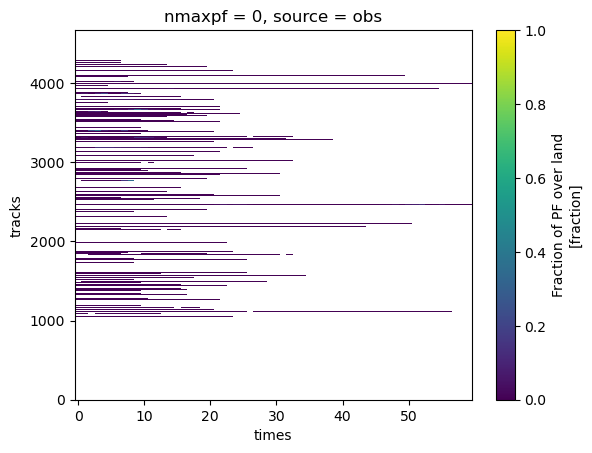

In [41]:
dss_pyflex_o.pf_landfrac.sel(source='obs').isel(times=slice(0,60)).plot()

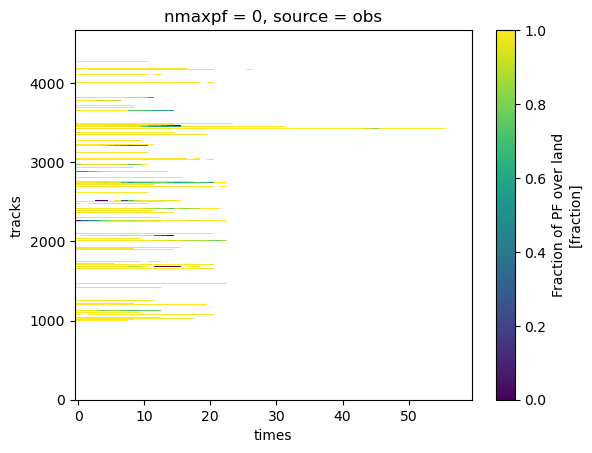

In [42]:
dss_pyflex_l.pf_landfrac.sel(source='obs').isel(times=slice(0,60)).plot()

In [43]:
dss_pyflex_l.pf_rainrate.attrs

{'long_name': 'Mean rain rate of PF', 'units': 'mm/h'}

## Use a simple method to separate possible merge/split tracks
### If max CCS area occur within the first x% of a tracks start time: split; or within last x% of a tracks end time: merge

In [44]:
# Set max area time fraction thresholds (if max area occur between these times, the track is retained)
max_timefrac_thresh = [0.1, 0.9]

# # MCS lifetime range for composites
# lifetime_range1 = [10, 12]
# lifetime_range2 = [20, 24]

# MCS lifetime quantiles
quantiles = [0.25, 0.5, 0.75]
# Buffer for lifetime range [hour]
buffer = 1

In [45]:
# Suppress RuntimeWarning messages
warnings.filterwarnings("ignore", category=RuntimeWarning)

# Get the relative fraction in time (from 0 to 1) when CCS reaches maximum
# Time index when CCS area is maximum divide by the track duration
maxccs_timefrac_pyflex_o = dss_pyflex_o.ccs_area.idxmax(dim='times', skipna=True) / dss_pyflex_o.track_duration
maxccs_timefrac_pyflex_l = dss_pyflex_l.ccs_area.idxmax(dim='times', skipna=True) / dss_pyflex_l.track_duration

# Masks for non-split
mask_nonsplit_o = maxccs_timefrac_pyflex_o > min(max_timefrac_thresh)
mask_nonsplit_l = maxccs_timefrac_pyflex_l > min(max_timefrac_thresh)
# Masks for non-merge-splot tracks
mask_nonmergesplit_o = (maxccs_timefrac_pyflex_o > min(max_timefrac_thresh)) & (maxccs_timefrac_pyflex_o < max(max_timefrac_thresh))
mask_nonmergesplit_l = (maxccs_timefrac_pyflex_l > min(max_timefrac_thresh)) & (maxccs_timefrac_pyflex_l < max(max_timefrac_thresh))
                   
# CCS lifetime [hour]
ccslifetime_pyflex_o = dss_pyflex_o.track_duration * time_resolution
ccslifetime_pyflex_l = dss_pyflex_l.track_duration * time_resolution

# # Composite the DataSets by lifetime
# # Short-lived
# ds1_pyflex_o = dss_pyflex_o.where((mask_nonmergesplit_o) & (ccslifetime_pyflex_o >= lifetime_range1[0]) & (ccslifetime_pyflex_o <= lifetime_range1[1])).mean(dim='tracks')
# ds1_pyflex_l = dss_pyflex_l.where((mask_nonmergesplit_l) & (ccslifetime_pyflex_l >= lifetime_range1[0]) & (ccslifetime_pyflex_l <= lifetime_range1[1])).mean(dim='tracks')
# # Long-lived
# ds2_pyflex_o = dss_pyflex_o.where((mask_nonmergesplit_o) & (ccslifetime_pyflex_o >= lifetime_range2[0]) & (ccslifetime_pyflex_o <= lifetime_range2[1])).mean(dim='tracks')
# ds2_pyflex_l = dss_pyflex_l.where((mask_nonmergesplit_l) & (ccslifetime_pyflex_l >= lifetime_range2[0]) & (ccslifetime_pyflex_l <= lifetime_range2[1])).mean(dim='tracks')

# Get lifetime percentile values
lifetime_ranges_pyflex_o = ccslifetime_pyflex_o.chunk(dict(source=-1)).quantile(quantiles, skipna=True).load()
lifetime_ranges_pyflex_l = ccslifetime_pyflex_l.chunk(dict(source=-1)).quantile(quantiles, skipna=True).load()
print(f'pyflex lifetime percentile values (ocean): {lifetime_ranges_pyflex_l.data}')
print(f'pyflex lifetime percentile values (land): {lifetime_ranges_pyflex_o.data}')

# Set a range around median lifetime
lifetime_range50_pyflex_o = [lifetime_ranges_pyflex_o.sel(quantile=0.5).item()-buffer,lifetime_ranges_pyflex_o.sel(quantile=0.5).item()+buffer]
lifetime_range50_pyflex_l = [lifetime_ranges_pyflex_l.sel(quantile=0.5).item()-buffer,lifetime_ranges_pyflex_l.sel(quantile=0.5).item()+buffer]
print(f'pyflex median lifetime range (ocean): {lifetime_range50_pyflex_o}')
print(f'pyflex median lifetime range (land): {lifetime_range50_pyflex_l}')

# Average DataSets for tracks with similar lifetime
ds50_pyflex_o = dss_pyflex_o.where((mask_nonmergesplit_o) & (ccslifetime_pyflex_o >= min(lifetime_range50_pyflex_o)) & (ccslifetime_pyflex_o <= max(lifetime_range50_pyflex_o))).mean(dim='tracks')
ds50_pyflex_l = dss_pyflex_l.where((mask_nonmergesplit_l) & (ccslifetime_pyflex_l >= min(lifetime_range50_pyflex_l)) & (ccslifetime_pyflex_l <= max(lifetime_range50_pyflex_l))).mean(dim='tracks')

pyflex lifetime percentile values (ocean): [11. 15. 21.]
pyflex lifetime percentile values (land): [11. 17. 25.]
pyflex median lifetime range (ocean): [16.0, 18.0]
pyflex median lifetime range (land): [14.0, 16.0]


(array([ 408.,  544.,  734.,  838.,  815., 1165.,  864.,  796.,  513.,
         418.]),
 array([0.10126582, 0.18093516, 0.26060449, 0.34027383, 0.41994317,
        0.4996125 , 0.57928184, 0.65895118, 0.73862051, 0.81828985,
        0.89795918]),
 <BarContainer object of 10 artists>)

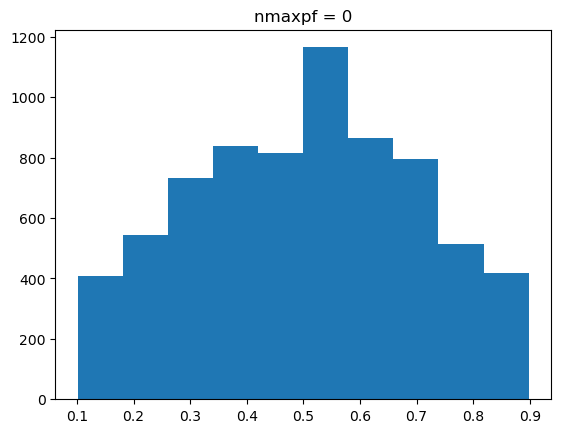

In [46]:
maxccs_timefrac_pyflex_o.where(mask_nonmergesplit_o).plot.hist()

In [47]:
# Suppress RuntimeWarning messages
warnings.filterwarnings("ignore", category=RuntimeWarning)

# Get the relative fraction in time (from 0 to 1) when CCS reaches maximum
# Time index when CCS area is maximum divide by the track duration
maxccs_timefrac_moaap_o = dss_moaap_o.ccs_area.idxmax(dim='times', skipna=True) / dss_moaap_o.track_duration
maxccs_timefrac_moaap_l = dss_moaap_l.ccs_area.idxmax(dim='times', skipna=True) / dss_moaap_l.track_duration

# Masks for non-split
mask_nonsplit_o = maxccs_timefrac_moaap_o > min(max_timefrac_thresh)
mask_nonsplit_l = maxccs_timefrac_moaap_l > min(max_timefrac_thresh)
# Masks for non-merge-splot tracks
mask_nonmergesplit_o = (maxccs_timefrac_moaap_o > min(max_timefrac_thresh)) & (maxccs_timefrac_moaap_o < max(max_timefrac_thresh))
mask_nonmergesplit_l = (maxccs_timefrac_moaap_l > min(max_timefrac_thresh)) & (maxccs_timefrac_moaap_l < max(max_timefrac_thresh))
                   
# CCS lifetime [hour]
ccslifetime_moaap_o = dss_moaap_o.track_duration * time_resolution
ccslifetime_moaap_l = dss_moaap_l.track_duration * time_resolution

# Get lifetime percentile values
lifetime_ranges_moaap_o = ccslifetime_moaap_o.chunk(dict(source=-1)).quantile(quantiles, skipna=True).load()
lifetime_ranges_moaap_l = ccslifetime_moaap_l.chunk(dict(source=-1)).quantile(quantiles, skipna=True).load()
print(f'moaap lifetime percentile values (ocean): {lifetime_ranges_moaap_l.data}')
print(f'moaap lifetime percentile values (land): {lifetime_ranges_moaap_o.data}')

# Set a range around median lifetime
lifetime_range50_moaap_o = [lifetime_ranges_moaap_o.sel(quantile=0.5).item()-buffer,lifetime_ranges_moaap_o.sel(quantile=0.5).item()+buffer]
lifetime_range50_moaap_l = [lifetime_ranges_moaap_l.sel(quantile=0.5).item()-buffer,lifetime_ranges_moaap_l.sel(quantile=0.5).item()+buffer]
print(f'moaap median lifetime range (ocean): {lifetime_range50_moaap_o}')
print(f'moaap median lifetime range (land): {lifetime_range50_moaap_l}')

# Average DataSets for tracks with similar lifetime
ds50_moaap_o = dss_moaap_o.where((mask_nonmergesplit_o) & (ccslifetime_moaap_o >= min(lifetime_range50_moaap_o)) & (ccslifetime_moaap_o <= max(lifetime_range50_moaap_o))).mean(dim='tracks')
ds50_moaap_l = dss_moaap_l.where((mask_nonmergesplit_l) & (ccslifetime_moaap_l >= min(lifetime_range50_moaap_l)) & (ccslifetime_moaap_l <= max(lifetime_range50_moaap_l))).mean(dim='tracks')

moaap lifetime percentile values (ocean): [21. 26. 33.]
moaap lifetime percentile values (land): [24. 30. 38.]
moaap median lifetime range (ocean): [29.0, 31.0]
moaap median lifetime range (land): [25.0, 27.0]


In [48]:
# Suppress RuntimeWarning messages
warnings.filterwarnings("ignore", category=RuntimeWarning)

# Get the relative fraction in time (from 0 to 1) when CCS reaches maximum
# Time index when CCS area is maximum divide by the track duration
maxccs_timefrac_toocan_o = dss_toocan_o.ccs_area.idxmax(dim='times', skipna=True) / dss_toocan_o.track_duration
maxccs_timefrac_toocan_l = dss_toocan_l.ccs_area.idxmax(dim='times', skipna=True) / dss_toocan_l.track_duration

# Masks for non-split
mask_nonsplit_o = maxccs_timefrac_toocan_o > min(max_timefrac_thresh)
mask_nonsplit_l = maxccs_timefrac_toocan_l > min(max_timefrac_thresh)
# Masks for non-merge-splot tracks
mask_nonmergesplit_o = (maxccs_timefrac_toocan_o > min(max_timefrac_thresh)) & (maxccs_timefrac_toocan_o < max(max_timefrac_thresh))
mask_nonmergesplit_l = (maxccs_timefrac_toocan_l > min(max_timefrac_thresh)) & (maxccs_timefrac_toocan_l < max(max_timefrac_thresh))
                   
# CCS lifetime [hour]
ccslifetime_toocan_o = dss_toocan_o.track_duration * time_resolution
ccslifetime_toocan_l = dss_toocan_l.track_duration * time_resolution

# Get lifetime percentile values
lifetime_ranges_toocan_o = ccslifetime_toocan_o.chunk(dict(source=-1)).quantile(quantiles, skipna=True).load()
lifetime_ranges_toocan_l = ccslifetime_toocan_l.chunk(dict(source=-1)).quantile(quantiles, skipna=True).load()
print(f'toocan lifetime percentile values (ocean): {lifetime_ranges_toocan_l.data}')
print(f'toocan lifetime percentile values (land): {lifetime_ranges_toocan_o.data}')

# Set a range around median lifetime
lifetime_range50_toocan_o = [lifetime_ranges_toocan_o.sel(quantile=0.5).item()-buffer,lifetime_ranges_toocan_o.sel(quantile=0.5).item()+buffer]
lifetime_range50_toocan_l = [lifetime_ranges_toocan_l.sel(quantile=0.5).item()-buffer,lifetime_ranges_toocan_l.sel(quantile=0.5).item()+buffer]
print(f'toocan median lifetime range (ocean): {lifetime_range50_toocan_o}')
print(f'toocan median lifetime range (land): {lifetime_range50_toocan_l}')

# Average DataSets for tracks with similar lifetime
ds50_toocan_o = dss_toocan_o.where((mask_nonmergesplit_o) & (ccslifetime_toocan_o >= min(lifetime_range50_toocan_o)) & (ccslifetime_toocan_o <= max(lifetime_range50_toocan_o))).mean(dim='tracks')
ds50_toocan_l = dss_toocan_l.where((mask_nonmergesplit_l) & (ccslifetime_toocan_l >= min(lifetime_range50_toocan_l)) & (ccslifetime_toocan_l <= max(lifetime_range50_toocan_l))).mean(dim='tracks')

toocan lifetime percentile values (ocean): [13. 15. 18.]
toocan lifetime percentile values (land): [14. 16. 19.]
toocan median lifetime range (ocean): [15.0, 17.0]
toocan median lifetime range (land): [14.0, 16.0]


In [49]:
# Suppress RuntimeWarning messages
warnings.filterwarnings("ignore", category=RuntimeWarning)

# Get the relative fraction in time (from 0 to 1) when CCS reaches maximum
# Time index when CCS area is maximum divide by the track duration
maxccs_timefrac_tobac_o = dss_tobac_o.ccs_area.idxmax(dim='times', skipna=True) / dss_tobac_o.track_duration
maxccs_timefrac_tobac_l = dss_tobac_l.ccs_area.idxmax(dim='times', skipna=True) / dss_tobac_l.track_duration

# Masks for non-split
mask_nonsplit_o = maxccs_timefrac_tobac_o > min(max_timefrac_thresh)
mask_nonsplit_l = maxccs_timefrac_tobac_l > min(max_timefrac_thresh)
# Masks for non-merge-splot tracks
mask_nonmergesplit_o = (maxccs_timefrac_tobac_o > min(max_timefrac_thresh)) & (maxccs_timefrac_tobac_o < max(max_timefrac_thresh))
mask_nonmergesplit_l = (maxccs_timefrac_tobac_l > min(max_timefrac_thresh)) & (maxccs_timefrac_tobac_l < max(max_timefrac_thresh))
                   
# CCS lifetime [hour]
ccslifetime_tobac_o = dss_tobac_o.track_duration * time_resolution
ccslifetime_tobac_l = dss_tobac_l.track_duration * time_resolution

# Get lifetime percentile values
lifetime_ranges_tobac_o = ccslifetime_tobac_o.chunk(dict(source=-1)).quantile(quantiles, skipna=True).load()
lifetime_ranges_tobac_l = ccslifetime_tobac_l.chunk(dict(source=-1)).quantile(quantiles, skipna=True).load()
print(f'tobac lifetime percentile values (ocean): {lifetime_ranges_tobac_l.data}')
print(f'tobac lifetime percentile values (land): {lifetime_ranges_tobac_o.data}')

# Set a range around median lifetime
lifetime_range50_tobac_o = [lifetime_ranges_tobac_o.sel(quantile=0.5).item()-buffer,lifetime_ranges_tobac_o.sel(quantile=0.5).item()+buffer]
lifetime_range50_tobac_l = [lifetime_ranges_tobac_l.sel(quantile=0.5).item()-buffer,lifetime_ranges_tobac_l.sel(quantile=0.5).item()+buffer]
print(f'tobac median lifetime range (ocean): {lifetime_range50_tobac_o}')
print(f'tobac median lifetime range (land): {lifetime_range50_tobac_l}')

# Average DataSets for tracks with similar lifetime
ds50_tobac_o = dss_tobac_o.where((mask_nonmergesplit_o) & (ccslifetime_tobac_o >= min(lifetime_range50_tobac_o)) & (ccslifetime_tobac_o <= max(lifetime_range50_tobac_o))).mean(dim='tracks')
ds50_tobac_l = dss_tobac_l.where((mask_nonmergesplit_l) & (ccslifetime_tobac_l >= min(lifetime_range50_tobac_l)) & (ccslifetime_tobac_l <= max(lifetime_range50_tobac_l))).mean(dim='tracks')

tobac lifetime percentile values (ocean): [11. 15. 20.]
tobac lifetime percentile values (land): [11. 16. 23.]
tobac median lifetime range (ocean): [15.0, 17.0]
tobac median lifetime range (land): [14.0, 16.0]


In [50]:
# Suppress RuntimeWarning messages
warnings.filterwarnings("ignore", category=RuntimeWarning)

# Get the relative fraction in time (from 0 to 1) when CCS reaches maximum
# Time index when CCS area is maximum divide by the track duration
maxccs_timefrac_tams_o = dss_tams_o.ccs_area.idxmax(dim='times', skipna=True) / dss_tams_o.track_duration
maxccs_timefrac_tams_l = dss_tams_l.ccs_area.idxmax(dim='times', skipna=True) / dss_tams_l.track_duration

# Masks for non-split
mask_nonsplit_o = maxccs_timefrac_tams_o > min(max_timefrac_thresh)
mask_nonsplit_l = maxccs_timefrac_tams_l > min(max_timefrac_thresh)
# Masks for non-merge-splot tracks
mask_nonmergesplit_o = (maxccs_timefrac_tams_o > min(max_timefrac_thresh)) & (maxccs_timefrac_tams_o < max(max_timefrac_thresh))
mask_nonmergesplit_l = (maxccs_timefrac_tams_l > min(max_timefrac_thresh)) & (maxccs_timefrac_tams_l < max(max_timefrac_thresh))
                   
# CCS lifetime [hour]
ccslifetime_tams_o = dss_tams_o.track_duration * time_resolution
ccslifetime_tams_l = dss_tams_l.track_duration * time_resolution

# Get lifetime percentile values
lifetime_ranges_tams_o = ccslifetime_tams_o.chunk(dict(source=-1)).quantile(quantiles, skipna=True).load()
lifetime_ranges_tams_l = ccslifetime_tams_l.chunk(dict(source=-1)).quantile(quantiles, skipna=True).load()
print(f'tams lifetime percentile values (ocean): {lifetime_ranges_tams_l.data}')
print(f'tams lifetime percentile values (land): {lifetime_ranges_tams_o.data}')

# Set a range around median lifetime
lifetime_range50_tams_o = [lifetime_ranges_tams_o.sel(quantile=0.5).item()-buffer,lifetime_ranges_tams_o.sel(quantile=0.5).item()+buffer]
lifetime_range50_tams_l = [lifetime_ranges_tams_l.sel(quantile=0.5).item()-buffer,lifetime_ranges_tams_l.sel(quantile=0.5).item()+buffer]
print(f'tams median lifetime range (ocean): {lifetime_range50_tams_o}')
print(f'tams median lifetime range (land): {lifetime_range50_tams_l}')

# Average DataSets for tracks with similar lifetime
ds50_tams_o = dss_tams_o.where((mask_nonmergesplit_o) & (ccslifetime_tams_o >= min(lifetime_range50_tams_o)) & (ccslifetime_tams_o <= max(lifetime_range50_tams_o))).mean(dim='tracks')
ds50_tams_l = dss_tams_l.where((mask_nonmergesplit_l) & (ccslifetime_tams_l >= min(lifetime_range50_tams_l)) & (ccslifetime_tams_l <= max(lifetime_range50_tams_l))).mean(dim='tracks')

tams lifetime percentile values (ocean): [ 7.  9. 13.]
tams lifetime percentile values (land): [ 7. 10. 15.]
tams median lifetime range (ocean): [9.0, 11.0]
tams median lifetime range (land): [8.0, 10.0]


In [51]:
# Suppress RuntimeWarning messages
warnings.filterwarnings("ignore", category=RuntimeWarning)

# Get the relative fraction in time (from 0 to 1) when CCS reaches maximum
# Time index when CCS area is maximum divide by the track duration
maxccs_timefrac_simtrack_o = dss_simtrack_o.ccs_area.idxmax(dim='times', skipna=True) / dss_simtrack_o.track_duration
maxccs_timefrac_simtrack_l = dss_simtrack_l.ccs_area.idxmax(dim='times', skipna=True) / dss_simtrack_l.track_duration

# Masks for non-split
mask_nonsplit_o = maxccs_timefrac_simtrack_o > min(max_timefrac_thresh)
mask_nonsplit_l = maxccs_timefrac_simtrack_l > min(max_timefrac_thresh)
# Masks for non-merge-splot tracks
mask_nonmergesplit_o = (maxccs_timefrac_simtrack_o > min(max_timefrac_thresh)) & (maxccs_timefrac_simtrack_o < max(max_timefrac_thresh))
mask_nonmergesplit_l = (maxccs_timefrac_simtrack_l > min(max_timefrac_thresh)) & (maxccs_timefrac_simtrack_l < max(max_timefrac_thresh))
                   
# CCS lifetime [hour]
ccslifetime_simtrack_o = dss_simtrack_o.track_duration * time_resolution
ccslifetime_simtrack_l = dss_simtrack_l.track_duration * time_resolution

# Get lifetime percentile values
lifetime_ranges_simtrack_o = ccslifetime_simtrack_o.chunk(dict(source=-1)).quantile(quantiles, skipna=True).load()
lifetime_ranges_simtrack_l = ccslifetime_simtrack_l.chunk(dict(source=-1)).quantile(quantiles, skipna=True).load()
print(f'simtrack lifetime percentile values (ocean): {lifetime_ranges_simtrack_l.data}')
print(f'simtrack lifetime percentile values (land): {lifetime_ranges_simtrack_o.data}')

# Set a range around median lifetime
lifetime_range50_simtrack_o = [lifetime_ranges_simtrack_o.sel(quantile=0.5).item()-buffer,lifetime_ranges_simtrack_o.sel(quantile=0.5).item()+buffer]
lifetime_range50_simtrack_l = [lifetime_ranges_simtrack_l.sel(quantile=0.5).item()-buffer,lifetime_ranges_simtrack_l.sel(quantile=0.5).item()+buffer]
print(f'simtrack median lifetime range (ocean): {lifetime_range50_simtrack_o}')
print(f'simtrack median lifetime range (land): {lifetime_range50_simtrack_l}')

# Average DataSets for tracks with similar lifetime
ds50_simtrack_o = dss_simtrack_o.where((mask_nonmergesplit_o) & (ccslifetime_simtrack_o >= min(lifetime_range50_simtrack_o)) & (ccslifetime_simtrack_o <= max(lifetime_range50_simtrack_o))).mean(dim='tracks')
ds50_simtrack_l = dss_simtrack_l.where((mask_nonmergesplit_l) & (ccslifetime_simtrack_l >= min(lifetime_range50_simtrack_l)) & (ccslifetime_simtrack_l <= max(lifetime_range50_simtrack_l))).mean(dim='tracks')

simtrack lifetime percentile values (ocean): [11. 15. 21.]
simtrack lifetime percentile values (land): [11. 17. 24.]
simtrack median lifetime range (ocean): [16.0, 18.0]
simtrack median lifetime range (land): [14.0, 16.0]


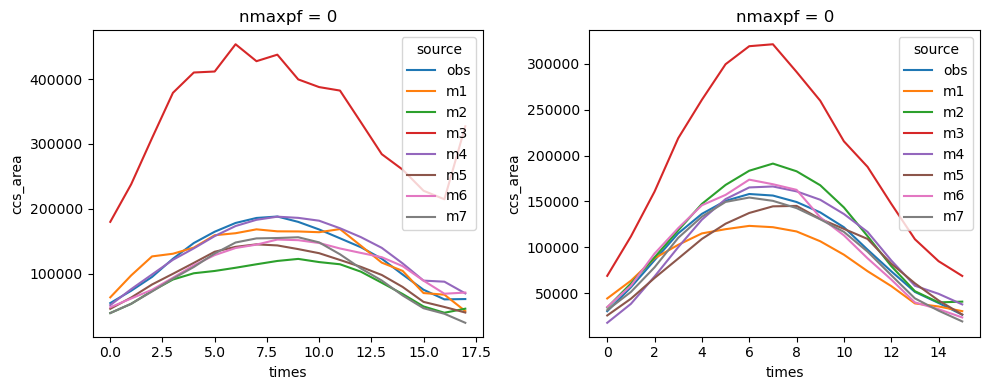

In [52]:
fig, axes = plt.subplots(1, 2, figsize=(10,4), dpi=100)
ds50_pyflex_o.ccs_area.plot.line(x='times', ax=axes[0])
ds50_pyflex_l.ccs_area.plot.line(x='times', ax=axes[1])
fig.tight_layout()

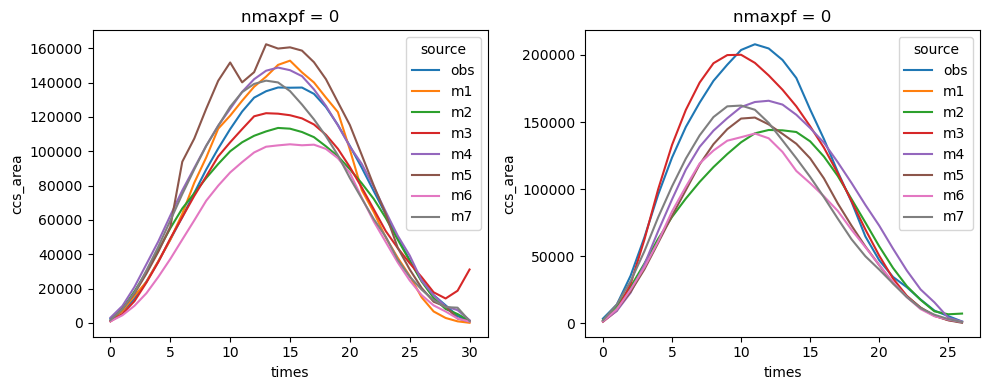

In [53]:
fig, axes = plt.subplots(1, 2, figsize=(10,4), dpi=100)
ds50_moaap_o.ccs_area.plot.line(x='times', ax=axes[0])
ds50_moaap_l.ccs_area.plot.line(x='times', ax=axes[1])
fig.tight_layout()

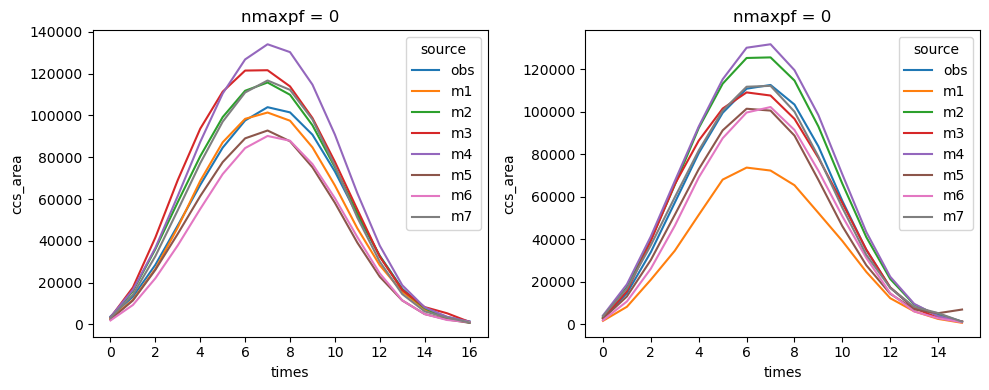

In [54]:
fig, axes = plt.subplots(1, 2, figsize=(10,4), dpi=100)
ds50_toocan_o.ccs_area.plot.line(x='times', ax=axes[0])
ds50_toocan_l.ccs_area.plot.line(x='times', ax=axes[1])
fig.tight_layout()

## Function to plot composite evolution

In [55]:
def plot_lines_mxn(nrow, ncol, data_arr, xtime, 
                 titles=None, titles_loc=None, title_ha=None, xlabels=None, ylabels=None, xticks=None, yticks=None, legends=None, legend_loc=None, legend_ncol=None,
                 fontsize=None, legend_fontsize=None, legend_anchor=None, xlims=None, ylims=None, col_labels=None, subtitle=None,
                 map_extent=None, lonbox=None, latbox=None, inset_param=None, figname=None, figsize=None, inset_flag=None):

    mpl.rcParams['font.size'] = fontsize
    mpl.rcParams['font.family'] = 'Helvetica'

    fig = plt.figure(figsize=figsize, dpi=100)
    gs = gridspec.GridSpec(nrow, ncol)
    gs.update(left=0.05, right=0.88, bottom=0.1, top=0.95, wspace=0.03, hspace=0.03)
    
    lcolors = {
        'obs':'k', 
        'm1': 'crimson',
        'm2': 'darkorange', 
        'm3': 'gold',
        'm4': 'green',
        'm5': 'turquoise',
        'm6': 'lime',
        'm7': 'blue',
        'm8': 'deepskyblue',
        'm9': 'purple',
        'm10': 'violet',
        'm11': 'deeppink',
    }
    lw = 1.5
    lws = {
        'obs': lw*3, 
        'm1': lw,
        'm2': lw, 
        'm3': lw,
        'm4': lw,
        'm5': lw,
        'm6': lw,
        'm7': lw,
        'm8': lw,
        'm9': lw,
        'm10': lw,
        'm11': lw,
    }
    
    # Loop over column and row
    for row in range(0, nrow):
        for col in range(0, ncol):
    
            ax = plt.subplot(gs[row,col], sharey=ax if col > 0 else None)
            # Plot title for each column
            xmin, xmax = ax.get_xlim()
            xmid = (xmin + xmax)/2
            if row == 0:
                ax.text(xmid, 1.05, col_labels[col], fontsize=fontsize*1.5, ha='center', transform=ax.transAxes)

            # Label x-axis for the last row
            if row == nrow-1:
                ax.set_xlabel(xlabels[col])
            else:
                ax.tick_params(axis='x', labelbottom=False)
            
            # Share y-axis for all columns in each row
            if col == 0:
                ax.set_ylabel(ylabels[row])
            else:
                ax.tick_params(axis='y', labelleft=False)
            # Hide the top and right spines
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            
            # Plot data
            for key in data_arr[row][col].source.data:
                idata = data_arr[row][col].sel(source=key)
                ax.plot(xtime, idata, lcolors[key], lw=lws[key], label=legends[key])
            # ax.axvline(x=0, lw=1, ls='--', color='k')
            ax.grid(which='major', ls='--', lw=0.5)
            if xticks is not None: ax.set_xticks(xticks)
            if ylims is not None: ax.set_ylim(ylims[col][0], ylims[col][1])
            if xlims is not None: ax.set_xlim(xlims[col][0], xlims[col][1])
            # ax.set_title(titles[row][col], loc='left')
            # Make title within the axis
            if titles is not None:
                flabel = ax.text(titles_loc[0], titles_loc[1], titles[row][col], ha=title_ha, transform=ax.transAxes, fontsize=fontsize)
                flabel.set_bbox(dict(facecolor='w', alpha=0.8, edgecolor='w'))
            if (row == 0) & (col == ncol-1):
                ax.legend(fontsize=legend_fontsize, loc=legend_loc, ncol=legend_ncol, bbox_to_anchor=legend_anchor)
            # Draw an arrow to show the direction of time increase
            if (row == nrow-1):
                ax.annotate('', xy=(1, -0.3), xytext=(0, -0.3), xycoords='axes fraction',
                            arrowprops=dict(arrowstyle="->", facecolor='k', lw=3))

    # Plot figure title
    fig.suptitle(subtitle, y=1.03, fontsize=fontsize*2)
    
    fig.savefig(figname, dpi=300, facecolor='w', bbox_inches='tight')
    return fig

### Put plotting variables in a list (Ocean)

In [56]:
pix_area = pixel_radius**2

# Data array [row][col]
data_arr_o = [
    [ds50_pyflex_o.ccs_area.load(), ds50_moaap_o.ccs_area.load(), ds50_toocan_o.ccs_area.load(), 
     ds50_tobac_o.ccs_area.load(), ds50_tams_o.ccs_area.load(), ds50_simtrack_o.ccs_area.load()],
    [ds50_pyflex_o.corecold_mintb.load(), ds50_moaap_o.corecold_mintb.load(), ds50_toocan_o.corecold_mintb.load(), 
     ds50_tobac_o.corecold_mintb.load(), ds50_tams_o.corecold_mintb.load(), ds50_simtrack_o.corecold_mintb.load()],
    [ds50_pyflex_o.pf_area.load(), ds50_moaap_o.pf_area.load(), ds50_toocan_o.pf_area.load(), 
     ds50_tobac_o.pf_area.load(), ds50_tams_o.pf_area.load(), ds50_simtrack_o.pf_area.load()],
    [ds50_pyflex_o.pf_rainrate.load(), ds50_moaap_o.pf_rainrate.load(), ds50_toocan_o.pf_rainrate.load(), 
     ds50_tobac_o.pf_rainrate.load(), ds50_tams_o.pf_rainrate.load(), ds50_simtrack_o.pf_rainrate.load()],
    [ds50_pyflex_o.total_rain.load()*pix_area, ds50_moaap_o.total_rain.load()*pix_area, ds50_toocan_o.total_rain.load()*pix_area, 
     ds50_tobac_o.total_rain.load()*pix_area, ds50_tams_o.total_rain.load()*pix_area, ds50_simtrack_o.total_rain.load()*pix_area],
]
xtime = ds50_pyflex_o.times.load()

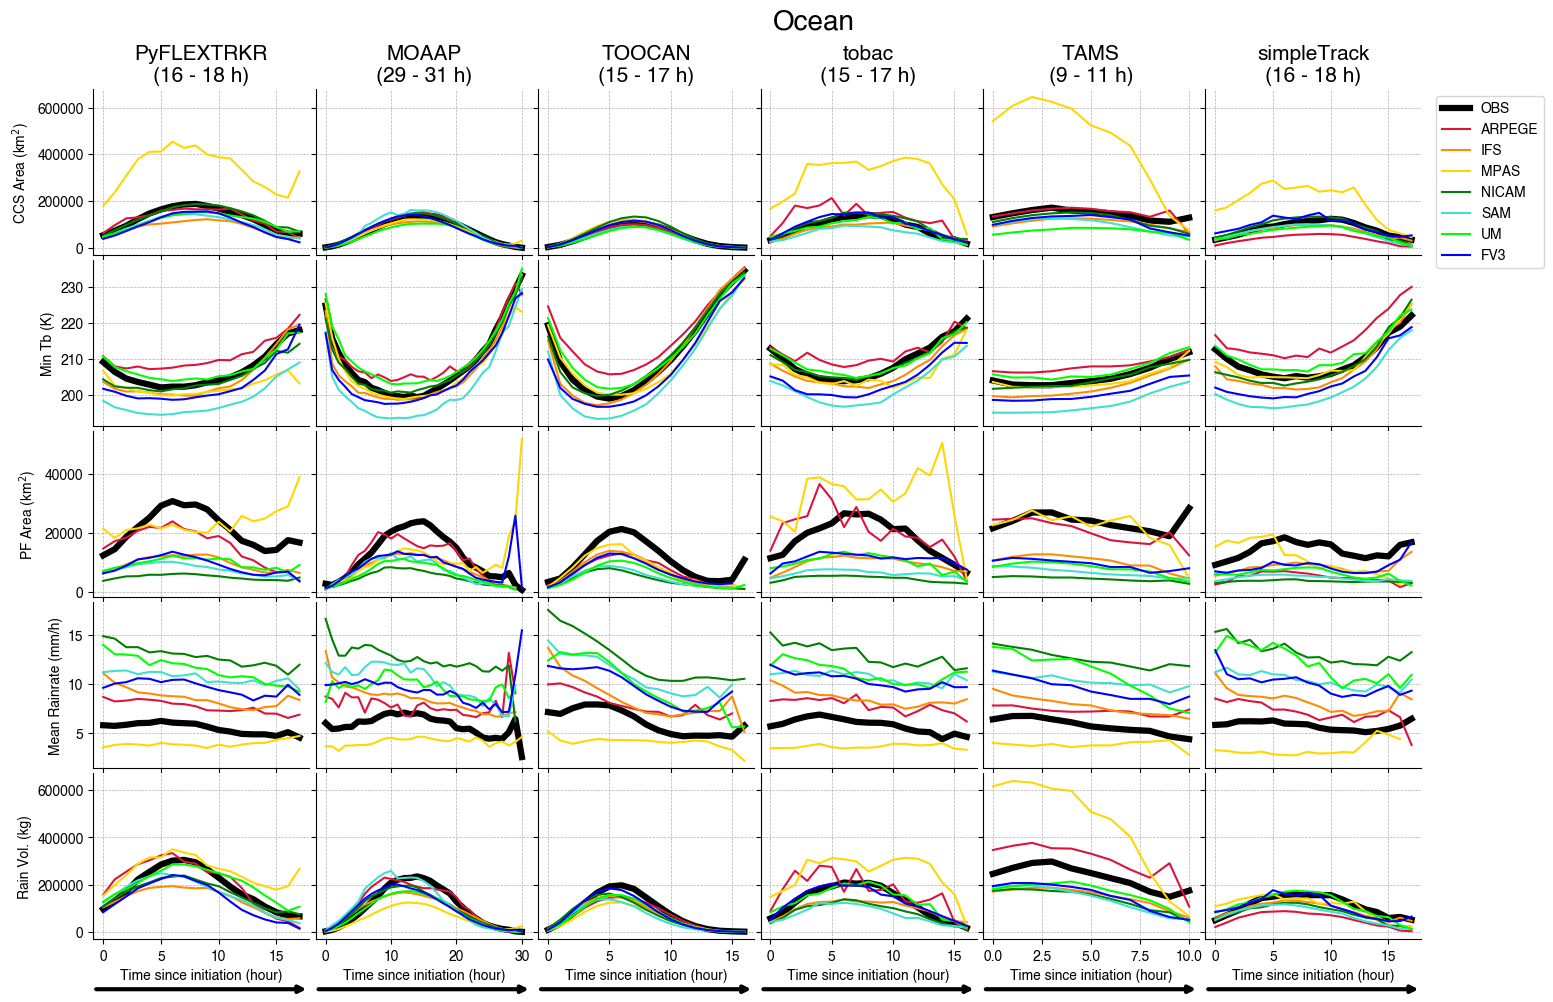

In [57]:
subtitle = 'Ocean'
legends = name_map
# col_labels = ['PyFLEXTRKR', 'MOAAP', 'TOOCAN', 'tobac', 'TAMS', 'simpleTrack']
col_labels = [
    f'PyFLEXTRKR\n({lifetime_range50_pyflex_o[0]:.0f} - {lifetime_range50_pyflex_o[1]:.0f} h)',
    f'MOAAP\n({lifetime_range50_moaap_o[0]:.0f} - {lifetime_range50_moaap_o[1]:.0f} h)',
    f'TOOCAN\n({lifetime_range50_toocan_o[0]:.0f} - {lifetime_range50_toocan_o[1]:.0f} h)',
    f'tobac\n({lifetime_range50_tobac_o[0]:.0f} - {lifetime_range50_tobac_o[1]:.0f} h)',
    f'TAMS\n({lifetime_range50_tams_o[0]:.0f} - {lifetime_range50_tams_o[1]:.0f} h)',
    f'simpleTrack\n({lifetime_range50_simtrack_o[0]:.0f} - {lifetime_range50_simtrack_o[1]:.0f} h)',
]
nrow = len(data_arr_o)
ncol = len(col_labels)
titles = None
# titles = [
#     ['(a) ', '(b) ', '(c)', '(d)', '(e)', '(f)'],
# ]
titles_loc = [0.97, 0.88]
title_ha = 'right'
xlabels = ['Time since initiation (hour)']*ncol
ylabels = ['CCS Area (km$^2$)', 'Min Tb (K)', 'PF Area (km$^2$)', 'Mean Rainrate (mm/h)', 'Rain Vol. (kg)']
# xlims = [(-25,40),(-25,40)]
xticks = None
xlims = None
# ylims = [(49,70),(43,60)]
# yticks = []
ylims = None
legend_loc = 'upper right'
legend_ncol = 1
legend_anchor = (1.6, 1)
fontsize = 10
legend_fontsize = 10
figsize = [16,10]
figname = f'{figdir}mcs_composite_timeseries_ocean_all.png'

fig = plot_lines_mxn(nrow, ncol, data_arr_o, xtime, 
                   titles=titles, titles_loc=titles_loc, title_ha=title_ha, xlabels=xlabels, ylabels=ylabels, xticks=xticks, legends=legends, legend_loc=legend_loc, legend_ncol=legend_ncol,
                   fontsize=fontsize, legend_fontsize=legend_fontsize, legend_anchor=legend_anchor, xlims=xlims, ylims=ylims, col_labels=col_labels,
                   subtitle=subtitle, figname=figname, figsize=figsize)

### Put plotting variables in a list (Land)

In [58]:
pix_area = pixel_radius**2

# Data array [row][col]
data_arr_l = [
    [ds50_pyflex_l.ccs_area.load(), ds50_moaap_l.ccs_area.load(), ds50_toocan_l.ccs_area.load(), 
     ds50_tobac_l.ccs_area.load(), ds50_tams_l.ccs_area.load(), ds50_simtrack_l.ccs_area.load()],
    [ds50_pyflex_l.corecold_mintb.load(), ds50_moaap_l.corecold_mintb.load(), ds50_toocan_l.corecold_mintb.load(), 
     ds50_tobac_l.corecold_mintb.load(), ds50_tams_l.corecold_mintb.load(), ds50_simtrack_l.corecold_mintb.load()],
    [ds50_pyflex_l.pf_area.load(), ds50_moaap_l.pf_area.load(), ds50_toocan_l.pf_area.load(), 
     ds50_tobac_l.pf_area.load(), ds50_tams_l.pf_area.load(), ds50_simtrack_l.pf_area.load()],
    [ds50_pyflex_l.pf_rainrate.load(), ds50_moaap_l.pf_rainrate.load(), ds50_toocan_l.pf_rainrate.load(), 
     ds50_tobac_l.pf_rainrate.load(), ds50_tams_l.pf_rainrate.load(), ds50_simtrack_l.pf_rainrate.load()],
    [ds50_pyflex_l.total_rain.load()*pix_area, ds50_moaap_l.total_rain.load()*pix_area, ds50_toocan_l.total_rain.load()*pix_area, 
     ds50_tobac_l.total_rain.load()*pix_area, ds50_tams_l.total_rain.load()*pix_area, ds50_simtrack_l.total_rain.load()*pix_area],
]
xtime = ds50_pyflex_l.times.load()

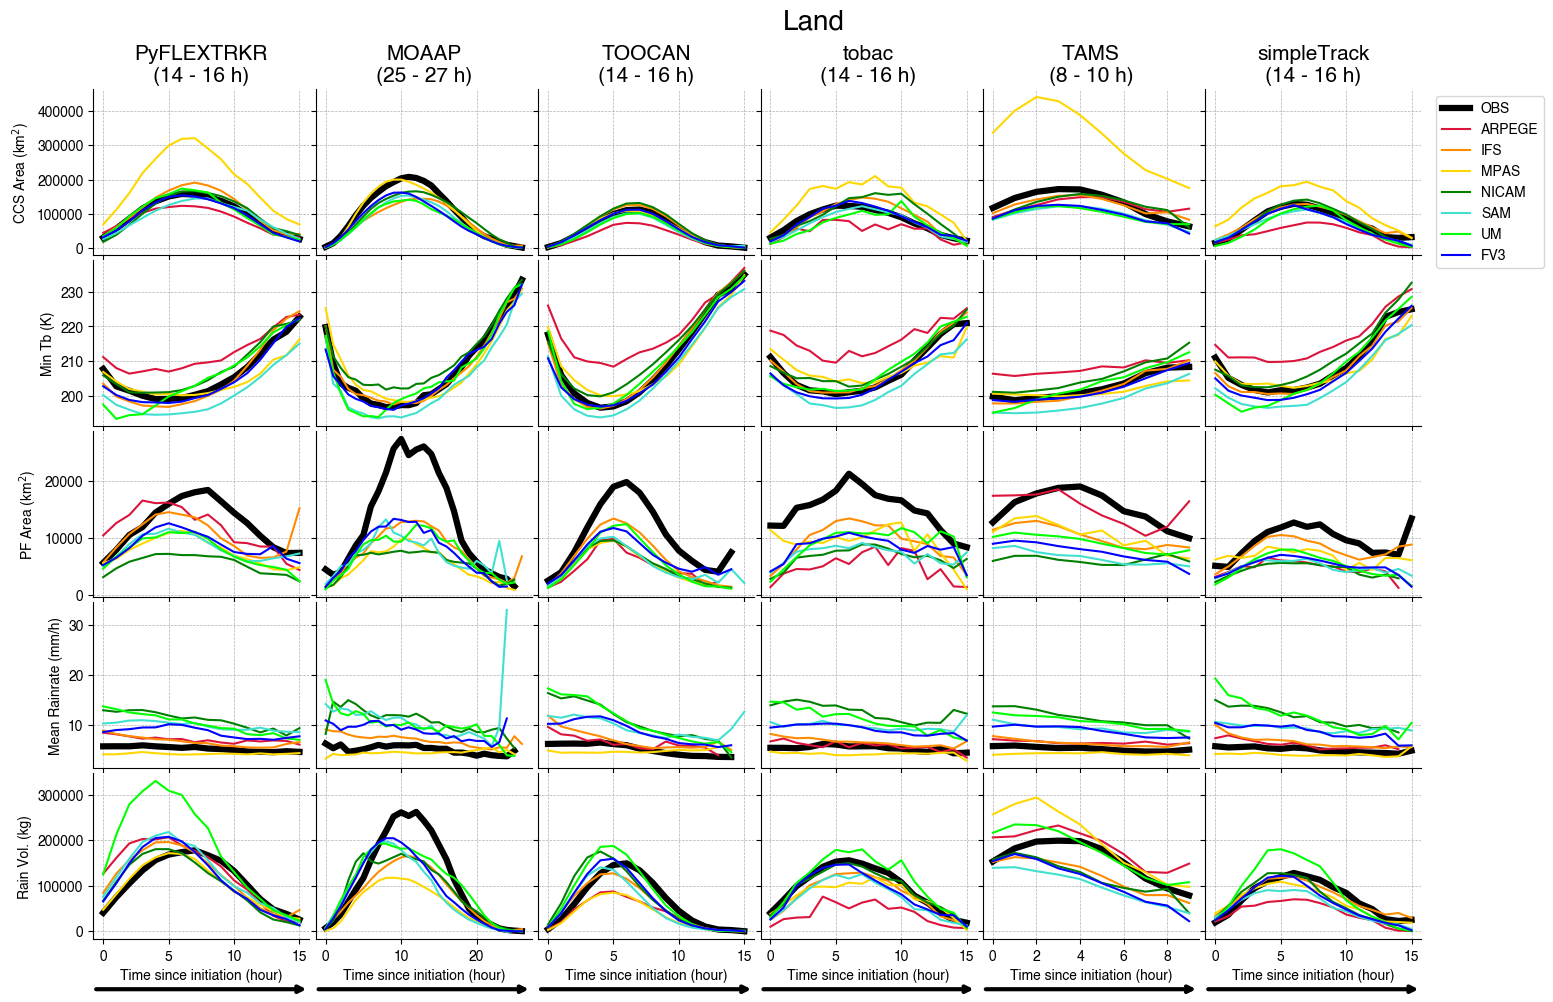

In [59]:
subtitle = 'Land'
legends = name_map
# col_labels = ['PyFLEXTRKR', 'MOAAP', 'TOOCAN', 'tobac', 'TAMS', 'simpleTrack']
col_labels = [
    f'PyFLEXTRKR\n({lifetime_range50_pyflex_l[0]:.0f} - {lifetime_range50_pyflex_l[1]:.0f} h)',
    f'MOAAP\n({lifetime_range50_moaap_l[0]:.0f} - {lifetime_range50_moaap_l[1]:.0f} h)',
    f'TOOCAN\n({lifetime_range50_toocan_l[0]:.0f} - {lifetime_range50_toocan_l[1]:.0f} h)',
    f'tobac\n({lifetime_range50_tobac_l[0]:.0f} - {lifetime_range50_tobac_l[1]:.0f} h)',
    f'TAMS\n({lifetime_range50_tams_l[0]:.0f} - {lifetime_range50_tams_l[1]:.0f} h)',
    f'simpleTrack\n({lifetime_range50_simtrack_l[0]:.0f} - {lifetime_range50_simtrack_l[1]:.0f} h)',
]
col_labels
nrow = len(data_arr_l)
ncol = len(col_labels)
titles = None
# titles = [
#     ['(a) ', '(b) ', '(c)', '(d)', '(e)', '(f)'],
# ]
titles_loc = [0.97, 0.88]
title_ha = 'right'
xlabels = ['Time since initiation (hour)']*ncol
ylabels = ['CCS Area (km$^2$)', 'Min Tb (K)', 'PF Area (km$^2$)', 'Mean Rainrate (mm/h)', 'Rain Vol. (kg)']
# xlims = [(-25,40),(-25,40)]
xticks = None
xlims = None
# ylims = [(49,70),(43,60)]
# yticks = []
ylims = None
legend_loc = 'upper right'
legend_ncol = 1
legend_anchor = (1.6, 1)
fontsize = 10
legend_fontsize = 10
figsize = [16,10]
figname = f'{figdir}mcs_composite_timeseries_land_all.png'

fig = plot_lines_mxn(nrow, ncol, data_arr_l, xtime, 
                   titles=titles, titles_loc=titles_loc, title_ha=title_ha, xlabels=xlabels, ylabels=ylabels, xticks=xticks, legends=legends, legend_loc=legend_loc, legend_ncol=legend_ncol,
                   fontsize=fontsize, legend_fontsize=legend_fontsize, legend_anchor=legend_anchor, xlims=xlims, ylims=ylims, col_labels=col_labels,
                   subtitle=subtitle, figname=figname, figsize=figsize)

In [60]:
figname

'/global/cfs/cdirs/m1867/zfeng/MCSMIP/DYAMOND/Summer/figures/MCSMIP/mcs_composite_timeseries_land_all.png'